In [27]:
"""
03_process_demand_data.py - Process raw energy demand data for Italy

This script processes raw energy demand data for Italy:
- Loads raw data from data/raw/energy_demand/Italy/consumption20XX.csv (2015–2024)
- Cleans and standardizes the data format
- Aggregates hourly data to daily average demand
- Handles missing values and outliers
- Saves processed data to data/processed/Italy/consumption20XX_p.csv
- Concatenates all years and merges with price data (PUN_p.csv)
- Saves final dataset to data/final/Italy/energy_demand2015_2024.csv
- Generates statistics and diagnostic plots
"""

'\n03_process_demand_data.py - Process raw energy demand data for Italy\n\nThis script processes raw energy demand data for Italy:\n- Loads raw data from data/raw/energy_demand/Italy/consumption20XX.csv (2015–2024)\n- Cleans and standardizes the data format\n- Aggregates hourly data to daily average demand\n- Handles missing values and outliers\n- Saves processed data to data/processed/Italy/consumption20XX_p.csv\n- Concatenates all years and merges with price data (PUN_p.csv)\n- Saves final dataset to data/final/Italy/energy_demand2015_2024.csv\n- Generates statistics and diagnostic plots\n'

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import datetime as dt

In [29]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [30]:
BASE_DIR = Path(os.getcwd()).parent
RAW_DIR = BASE_DIR / 'data/raw/energy_demand/Italy'
PROCESSED_DIR = BASE_DIR / 'data/processed/Italy'
FINAL_DIR = BASE_DIR / 'data/final/Italy'
IMAGES_DIR = BASE_DIR / 'outputs/images'
PRICE_DATA_PATH = BASE_DIR / 'data/processed/Italy/PUN_p.csv'

In [31]:
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)
FINAL_DIR.mkdir(exist_ok=True, parents=True)
IMAGES_DIR.mkdir(exist_ok=True, parents=True)

In [32]:
def load_and_process_year(year):
    """Load and process a single year's demand data"""
    file_path = RAW_DIR / f'consumption{year}.csv'
    print(f"Processing {file_path}...")
    if not file_path.exists():
        print(f"File not found: {file_path}")
        return None
    df = pd.read_csv(file_path)
    # Use explicit datetime and demand column names
    datetime_col = 'Time (CET/CEST)'
    demand_col = [col for col in df.columns if 'Actual Total Load' in col][0]
    # Convert to datetime (extract start time if range)
    df[datetime_col] = df[datetime_col].str.split(' - ').str[0]
    df[datetime_col] = pd.to_datetime(df[datetime_col], format='%d.%m.%Y %H:%M')
    # Standardize column names
    df = df.rename(columns={datetime_col: 'datetime', demand_col: 'demand_mw'})
    # Remove duplicates
    df = df.drop_duplicates(subset=['datetime'])
    # Handle missing values in demand
    missing = df['demand_mw'].isna().sum()
    if missing > 0:
        df = df.set_index('datetime')
        df['demand_mw'] = df['demand_mw'].interpolate(method='time')
        df['demand_mw'] = df['demand_mw'].fillna(method='bfill').fillna(method='ffill')
        df = df.reset_index()
    # Aggregate to daily average
    df['date'] = df['datetime'].dt.date
    daily = df.groupby('date')['demand_mw'].mean().reset_index()
    daily['date'] = pd.to_datetime(daily['date'])
    # Outlier detection (IQR)
    Q1 = daily['demand_mw'].quantile(0.25)
    Q3 = daily['demand_mw'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    daily['is_outlier'] = (daily['demand_mw'] < lower) | (daily['demand_mw'] > upper)
    # Add year, month, day
    daily['year'] = daily['date'].dt.year
    daily['month'] = daily['date'].dt.month
    daily['day'] = daily['date'].dt.day
    # Save processed file
    out_path = PROCESSED_DIR / f'consumption{year}_p.csv'
    daily.to_csv(out_path, index=False)
    print(f"Saved processed file: {out_path}")
    return daily

In [33]:
def generate_statistics_and_plots(df):
    print("Generating statistics and plots...")
    # Basic stats
    print(df['demand_mw'].describe())
    # Yearly averages
    print("Yearly averages:")
    print(df.groupby('year')['demand_mw'].mean())
    # Monthly averages
    print("Monthly averages:")
    print(df.groupby('month')['demand_mw'].mean())
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['demand_mw'], color='green', alpha=0.7)
    plt.title('Daily Average Energy Demand (2015-2024)')
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'demand_timeseries.png', dpi=300)
    # Yearly boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='year', y='demand_mw', data=df)
    plt.title('Energy Demand Distribution by Year')
    plt.xlabel('Year')
    plt.ylabel('Demand (MW)')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'yearly_demand_distribution.png', dpi=300)
    # Monthly boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='month', y='demand_mw', data=df)
    plt.title('Energy Demand Distribution by Month')
    plt.xlabel('Month')
    plt.ylabel('Demand (MW)')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_demand_distribution.png', dpi=300)
    # Distribution plot
    plt.figure(figsize=(12, 6))
    sns.histplot(df['demand_mw'], kde=True, bins=30, color='green')
    plt.title('Energy Demand Distribution')
    plt.xlabel('Demand (MW)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'demand_distribution.png', dpi=300)
    # Outlier plot
    if 'is_outlier' in df.columns and df['is_outlier'].sum() > 0:
        plt.figure(figsize=(12, 6))
        plt.scatter(df['date'], df['demand_mw'], 
                    c=df['is_outlier'].map({True: 'red', False: 'blue'}),
                    alpha=0.7)
        plt.title('Energy Demand Outliers')
        plt.xlabel('Date')
        plt.ylabel('Demand (MW)')
        plt.tight_layout()
        plt.savefig(IMAGES_DIR / 'demand_outliers.png', dpi=300)
    print(f"Plots saved to {IMAGES_DIR}")

Starting demand data processing...
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_demand/Italy/consumption2015.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/consumption2015_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_demand/Italy/consumption2016.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/consumption2016_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_demand/Italy/consumption2017.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/consumption2017_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_demand/Italy/consumption2018.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/consumption2018_p.csv
Proce

/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_84004/3875379876.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['demand_mw'] = df['demand_mw'].fillna(method='bfill').fillna(method='ffill')
/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_84004/3875379876.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['demand_mw'] = df['demand_mw'].fillna(method='bfill').fillna(method='ffill')
/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_84004/3875379876.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['demand_mw'] = df['demand_mw'].fillna(method='bfill').fillna(method='ffill')
/var/folders/4y/dxs3znt16fgcsl556_td55sh0000gn/T/ipykernel_84004/3875379876.py:24: FutureWarning: Series.f

Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/consumption2022_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_demand/Italy/consumption2023.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/consumption2023_p.csv
Processing /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/raw/energy_demand/Italy/consumption2024.csv...
Saved processed file: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/processed/Italy/consumption2024_p.csv
Saved concatenated demand data (unmerged) to: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy/energy_demand2015_2024.csv
Saved merged demand-price data to: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy/energy_demand2015_2024_merged.csv (Columns: ['date', 'demand_mw', 'is_outlier', 'year', 'month', 'day', 'price_eur_mwh'])
Generating statistics a

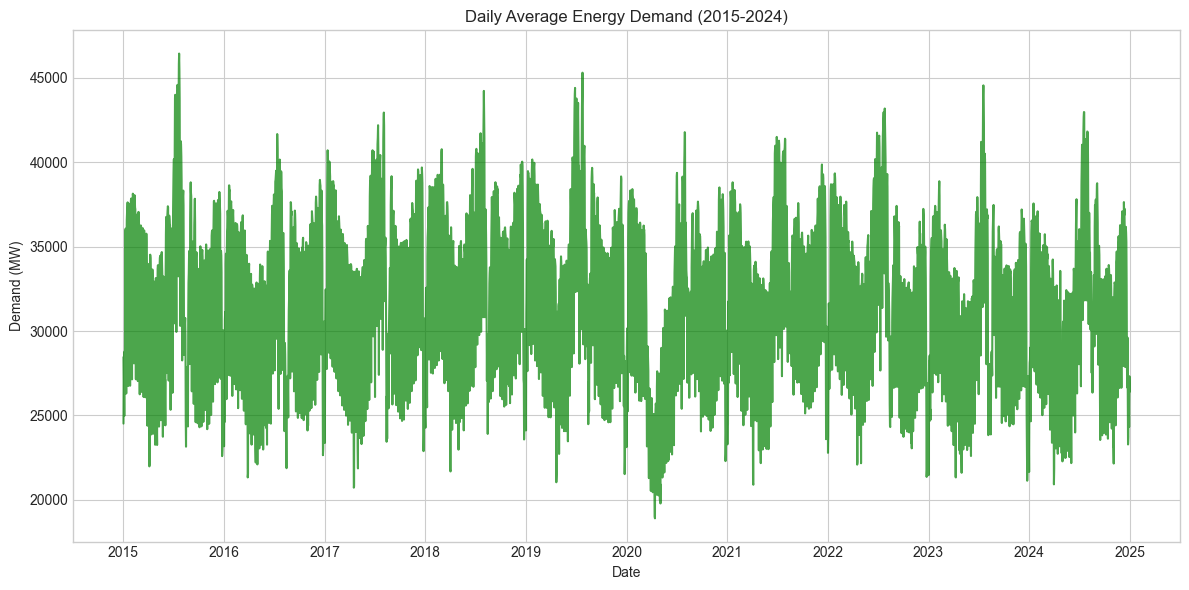

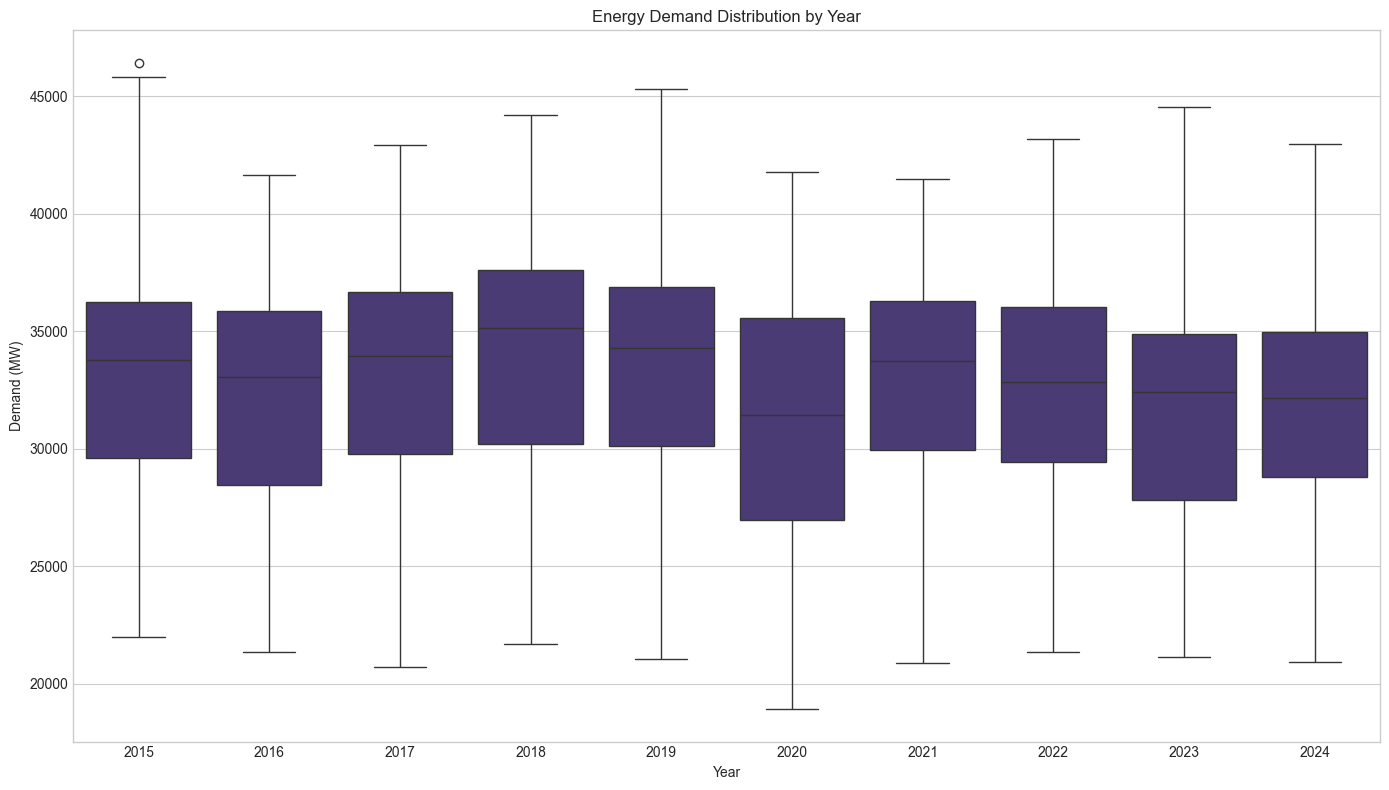

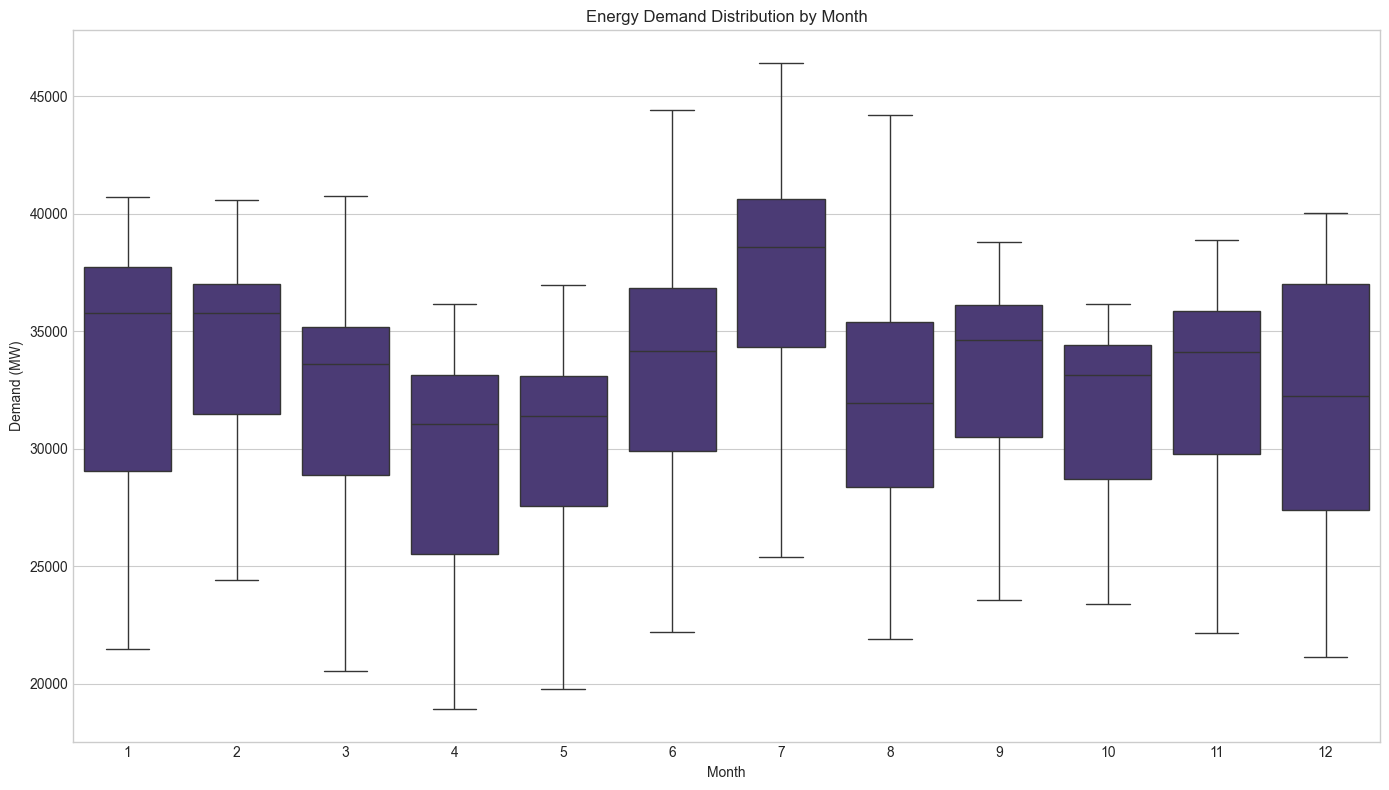

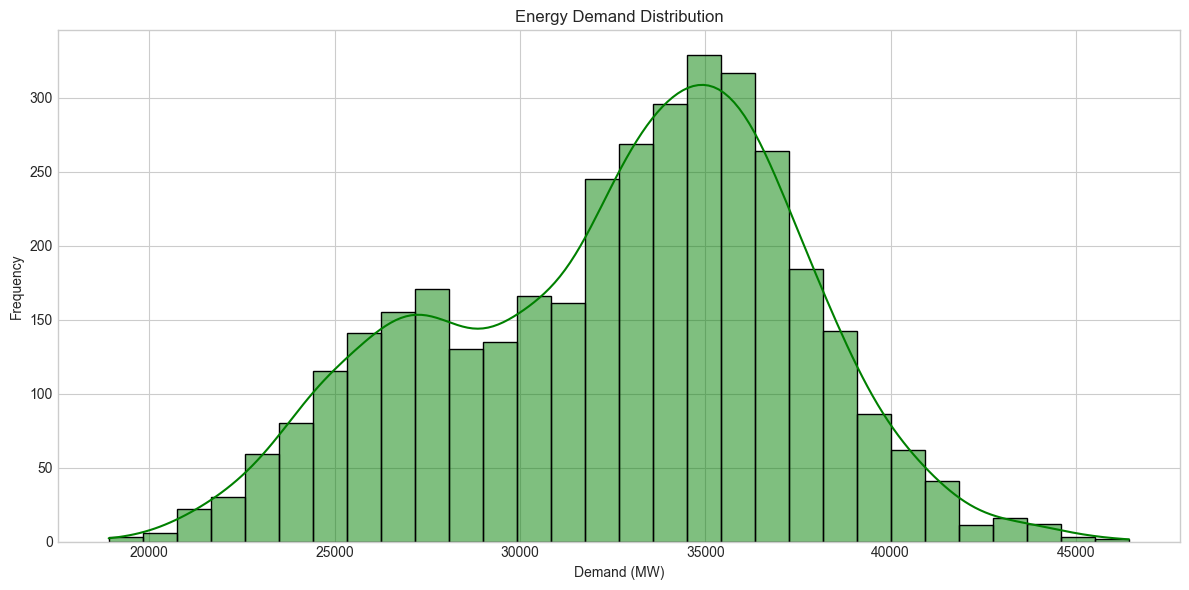

In [34]:
print("Starting demand data processing...")
all_years = []
for year in range(2015, 2025):
    daily = load_and_process_year(year)
    if daily is not None:
        all_years.append(daily)
if not all_years:
    print("No data processed.")
   
# Concatenate all years
df_all = pd.concat(all_years, ignore_index=True)
df_all = df_all.sort_values('date')
# Save concatenated data
concat_path = FINAL_DIR / 'energy_demand2015_2024.csv'
df_all.to_csv(concat_path, index=False)
print(f"Saved concatenated demand data (unmerged) to: {concat_path}")

# Merge with price data
if PRICE_DATA_PATH.exists():
    try:
        price_df_full = pd.read_csv(PRICE_DATA_PATH)

        # Select only necessary columns from price_df_full
        price_date_col_name = 'Date' if 'Date' in price_df_full.columns else 'date'
        
        cols_from_price_to_merge = [price_date_col_name]
        
        # Find the price_eur_mwh column, handling potential case variations or exact name
        price_eur_mwh_col_actual = None
        if 'price_eur_mwh' in price_df_full.columns:
            price_eur_mwh_col_actual = 'price_eur_mwh'
        else:
            for col in price_df_full.columns: # Fallback for case insensitivity or slight variations
                if 'price_eur_mwh' == col.lower():
                    price_eur_mwh_col_actual = col
                    break
        
        if price_eur_mwh_col_actual:
            cols_from_price_to_merge.append(price_eur_mwh_col_actual)
        else:
            print(f"Warning: 'price_eur_mwh' column not found in {PRICE_DATA_PATH}. Price will not be merged.")
            # If price_eur_mwh is critical and not found, you might choose to skip merging or raise an error.

        # Create a subset of price_df with only the date and price_eur_mwh columns
        if price_eur_mwh_col_actual: # Proceed only if price column was found
            price_df_subset = price_df_full[cols_from_price_to_merge].copy()
            
            # Standardize date column in the subset
            price_df_subset[price_date_col_name] = pd.to_datetime(price_df_subset[price_date_col_name])
            
            # Standardize demand data date column
            df_all['date'] = pd.to_datetime(df_all['date'])
            
            # Merge on date using the subset of price data
            merged = pd.merge(df_all, price_df_subset, 
                                left_on='date', 
                                right_on=price_date_col_name, # Use the original date column name from price_df for merge
                                how='left', 
                                suffixes=('_demand', '_price')) # Suffixes will apply if there's an unexpected name clash

            # If the price_date_col_name was different from 'date' (e.g., 'Date')
            # and you want to drop the redundant date column from price_df_subset after merge:
            if price_date_col_name in merged.columns and price_date_col_name != 'date':
                merged.drop(columns=[price_date_col_name], inplace=True)
        
        else: # price_eur_mwh column was not found in price_df_full
            print("Skipping merge with price data as 'price_eur_mwh' column was not identified.")
            merged = df_all.copy() # Proceed with just the demand data

        merged_path = FINAL_DIR / 'energy_demand2015_2024_merged.csv'
        merged.to_csv(merged_path, index=False)
        print(f"Saved merged demand-price data to: {merged_path} (Columns: {merged.columns.tolist()})")
    except Exception as e:
        print(f"Error merging with price data: {e}")
        # If merge fails, save the unmerged df_all to the target filename
        merged_path = FINAL_DIR / 'energy_demand2015_2024_merged.csv'
        df_all.to_csv(merged_path, index=False)
        print(f"Saved unmerged demand data to {merged_path} due to merge error.")
        raise
else:
    print(f"Price data not found at {PRICE_DATA_PATH}, skipping merge.")
    # If price file doesn't exist, save the unmerged df_all to the target filename
    merged_path = FINAL_DIR / 'energy_demand2015_2024_merged.csv'
    df_all.to_csv(merged_path, index=False)
    print(f"Saved demand data (unmerged) to {merged_path}")

# Generate statistics and plots
generate_statistics_and_plots(df_all)
print("Demand data processing complete!")
